In [1]:
from src.environment import NormalMoveGatedEnv
from src.experiment import Trajectory
from src.nn import BetaModel, Model, GeneralModel
from src.rl import Agent

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# %matplotlib inline

In [2]:
wolrd_size=10., 
punishment=-100, 
sigma=(.01, .3), 
tau=(1., -1.), 
start=([-5., -9.5],[9.5, -2.]), 
goals=[([7.5,7.5],[10.,10.])], 
walls=[([-8.,-1.],[10., 1.])],
gates=[([-10.,-1.],[-8., 1.])],
buttons=[([8.,-2.],[9.,-.5])],

In [3]:
env_params = {
    'walls': [([-8.,-1.],[10., 1.]), ([-1.,-8.],[1., 8.])],
    'goals': [([2.,2.],[3.,3.])],
    'start': ([7.,-9.9],[9.9,-7.]),
    'gates': [([-1.,-10.],[1., -8.]), ([-10.,-1.],[-8., 1.]), ([-1.,8.],[1., 10.])],
    'buttons': [([2.,-3.],[3.,-2.]), ([-3.,-3.],[-2.,-2.]), ([-3.,2.],[-2.,3.])],
    'beta': lambda s: (s[0]>0 and s[1]<0) or (s[0]<0 and s[1]>0)
}

[ 8.23702888 -7.70976544]
(array([ 7.2109237, -7.675068 ], dtype=float32), True, False)


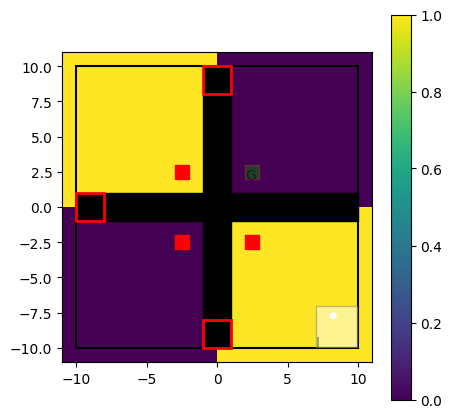

In [4]:
env = NormalMoveGatedEnv(**env_params)

s = env.reset()
print(s)
print(env.step(0))

ax = env.plot()

Trajectory size: 1
plan size: 64


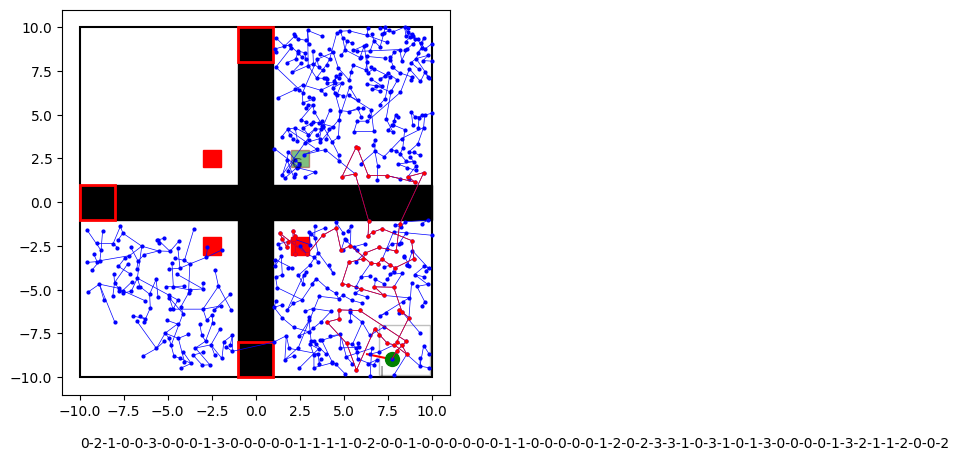

In [17]:
model_params = {
    "lr":1e-6, 
    'momentum':.9,
    'td_model_steps': 10, 
    'memory_size': 0, 
    'max_plan_size': 100, 
}
general_model_params = {
    'model': GeneralModel
}

model = Agent(env, **general_model_params, **model_params)

model.reset()
model.episode(size_limit=1)
# model.plot(kind='probs')
# model.plot()
model.plot(kind='plan', plan=0)
print(f'Trajectory size: {model.trajectory.run.shape[0]}')
print(f'plan size: {len(model.plans[0])}')

Parametros estimados para cada estado.
Trajectory size: 1101


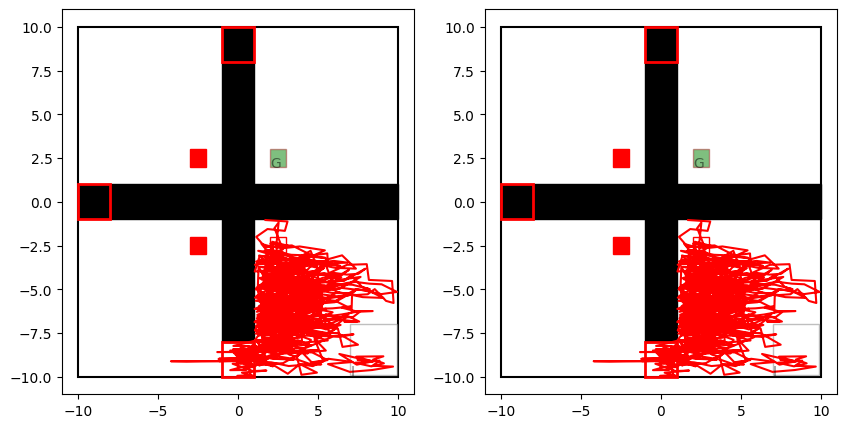

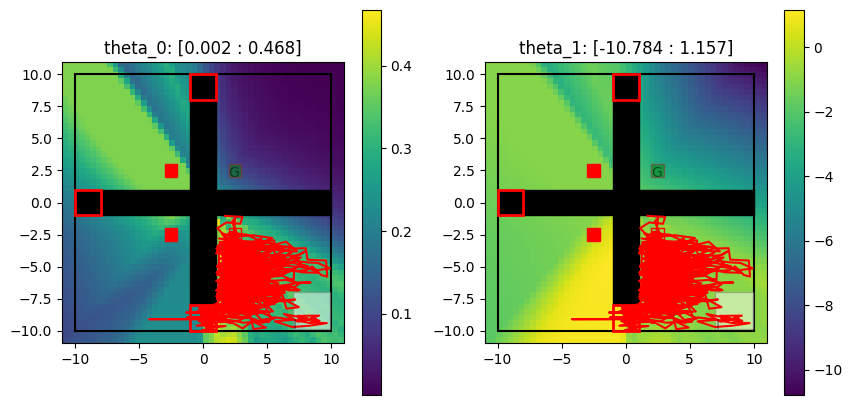

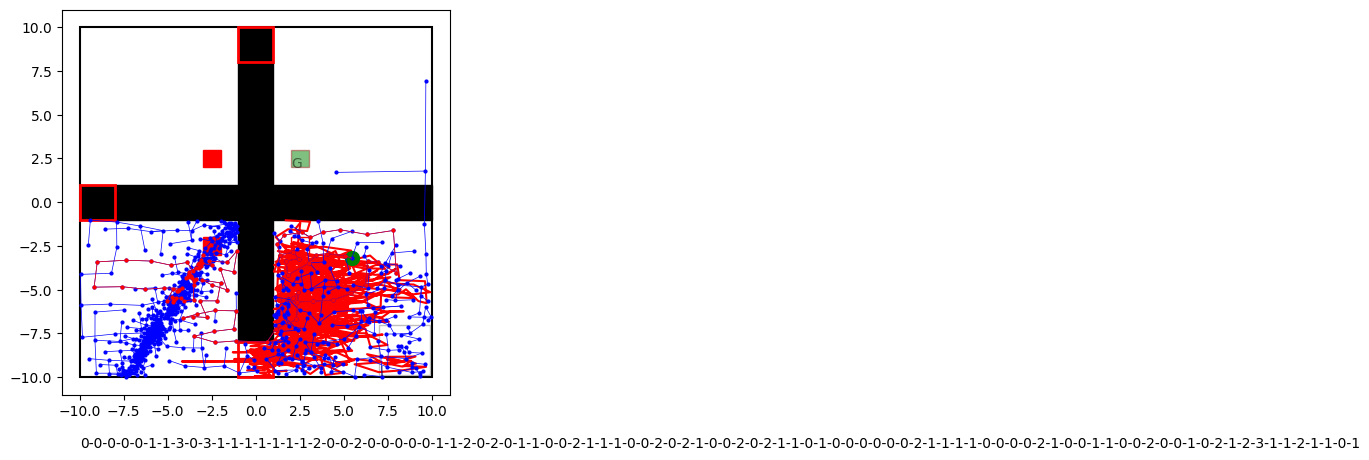

: 

In [24]:
model.episode(size_limit=300)
model.plot(kind='probs')
model.plot()
model.plot(kind='plan', plan=0)
print(f'Trajectory size: {model.trajectory.run.shape[0]}')

In [7]:
# dirs = {k:v for k,v in enumerate(['right', 'left', 'up', 'down'])}
print(len(model.plans[-1]))
print(model.plan_step)
print(sum([env.actions[n.cost] for n in model.plans[-1][::-1]][:model.plan_step-1]))
sum([env.actions[n.cost] for n in model.plans[-1][::-1]])

100
16
[9 0]


array([26, -6])

In [8]:
import pandas as pd
df_test = pd.DataFrame([{'a': n.cost, 's': n.value} for n in model.plans[-1][::-1]]).head(model.plan_step)
df = model.trajectory.run[['s','a','s_']].tail(model.plan_step).copy().reset_index()
df['a_planed'] = df_test.a
df['s_expected'] = df_test.s
df['pred_err'] = df.s_ - df.s_expected

df.head()

,index,s,a,s_,a_planed,s_expected,pred_err
0,0,"[8.521533, -5.144143]",0.0,"[7.9757876, -5.0748377]",0,"[8.120269, -5.205594]","[-0.14448118, 0.13075638]"
1,0,"[7.9757876, -5.0748377]",0.0,"[6.6459284, -5.048737]",0,"[7.5134773, -5.0701222]","[-0.86754894, 0.021385193]"
2,0,"[6.6459284, -5.048737]",0.0,"[5.6601195, -4.97685]",0,"[7.0774384, -5.3714414]","[-1.4173188, 0.39459133]"
3,0,"[5.6601195, -4.97685]",0.0,"[4.3666534, -5.43375]",0,"[6.353347, -5.2179074]","[-1.9866934, -0.21584272]"
4,0,"[4.3666534, -5.43375]",0.0,"[3.4153624, -5.4368377]",0,"[5.409092, -5.3406425]","[-1.9937296, -0.09619522]"


In [9]:
print('prediction err: ', (np.sum(df.pred_err**2)/df.shape[0])**.5)
print('predicted move: ', df.iloc[-1].s_expected - df.iloc[0].s_expected)
print('actual move: ', df.iloc[-1].s_ - df.iloc[0].s)

prediction err:  [1.0083526  0.41763088]
predicted move:  [-4.7684402  1.1616035]
actual move:  [-4.6154757  1.1035886]


# Testes

In [23]:
model.episode(size_limit=50)

print('plan steps: ',len(model.plans[-1]))
print('current step: ', model.plan_step)
print('current step value: ', model.plans[-1][::-1][model.plan_step-1].cost)
print('next step value: ', model.plans[-1][::-1][model.plan_step].cost)

model.trajectory.run[['s','a','s_']].tail(2)

plan steps:  97
current step:  3
current step value:  0
next step value:  0


,s,a,s_
0,"[-0.034746632, -9.823278]",0.0,"[0.9586249, -9.815556]"
0,"[0.9586249, -9.815556]",0.0,"[0.036841754, -9.154866]"


<AxesSubplot: >

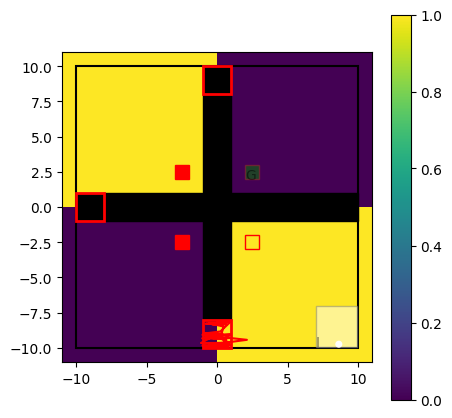

In [25]:
t = Trajectory()
t.run = model.trajectory.run[['s','a','s_']].tail(model.plan_step+50)

t.plot(env.plot()) 

<AxesSubplot: >

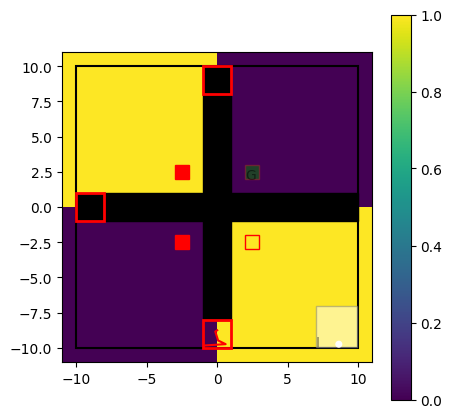

In [18]:
path = pd.DataFrame({'s':[n.value for n in model.plans[-1][::-1][:model.plan_step]], 
                     'a':[n.cost for n in model.plans[-1][::-1][:model.plan_step]],
                     's_':[n.value for n in model.plans[-1][::-1][:model.plan_step]]
                    })
t = Trajectory()
t.run = path

t.plot(env.plot())

<AxesSubplot: >

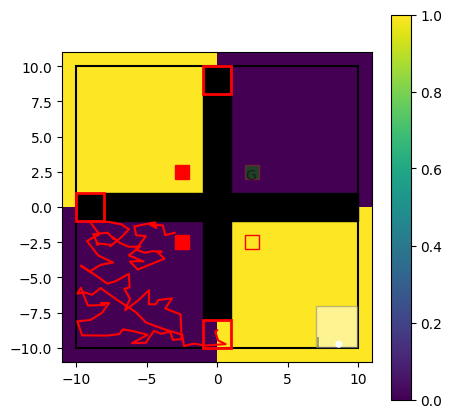

In [19]:
delta = 6

path = pd.DataFrame({'s':[n.value for n in model.plans[-1][::-1][:model.plan_step-delta]], 
                     'a':[n.cost for n in model.plans[-1][::-1][:model.plan_step-delta]],
                     's_':[n.value for n in model.plans[-1][::-1][:model.plan_step-delta]]
                    })
t = Trajectory()
t.run = path

t.plot(env.plot())

In [21]:
n = 0
plan = pd.DataFrame({'s_expected':[n.parent.value for n in model.plans[-1][::-1][:(model.plan_step-n)]], 
                     'a_planned':[n.cost for n in model.plans[-1][::-1][:(model.plan_step-n)]],
                     's__expected':[n.value for n in model.plans[-1][::-1][:(model.plan_step-n)]],
                     's': model.trajectory.run[['s','a','s_']].tail(model.plan_step)[:(model.plan_step-n)].s,
                     'a': model.trajectory.run[['s','a','s_']].tail(model.plan_step)[:(model.plan_step-n)].a,
                     's_': model.trajectory.run[['s','a','s_']].tail(model.plan_step)[:(model.plan_step-n)].s_,
                    })
plan.tail()

,s_expected,a_planned,s__expected,s,a,s_
0,"[0.837899, -8.927723]",0,"[0.0069988286, -8.749112]","[0.837899, -8.927723]",0.0,"[-0.15870789, -9.205361]"
0,"[0.0069988286, -8.749112]",0,"[-0.12907678, -8.838356]","[-0.15870789, -9.205361]",0.0,"[0.8306734, -9.205246]"
0,"[-0.12907678, -8.838356]",0,"[0.07226648, -9.471005]","[0.8306734, -9.205246]",0.0,"[0.067101106, -9.294868]"
0,"[0.07226648, -9.471005]",2,"[0.6074429, -9.733971]","[0.067101106, -9.294868]",2.0,"[0.067101106, -9.294868]"
0,"[0.6074429, -9.733971]",0,"[-0.88060266, -9.826512]","[0.067101106, -9.294868]",0.0,"[-1.042743, -9.07584]"


<AxesSubplot: >

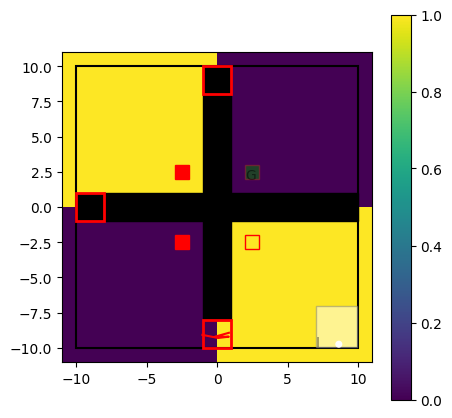

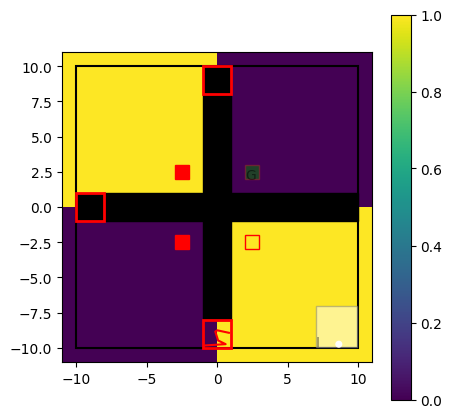

In [22]:
n = 0
plan = pd.DataFrame({'s_expected':[n.parent.value for n in model.plans[-1][::-1][:(model.plan_step-n)]], 
                     'a_planned':[n.cost for n in model.plans[-1][::-1][:(model.plan_step-n)]],
                     's__expected':[n.value for n in model.plans[-1][::-1][:(model.plan_step-n)]],
                     's': model.trajectory.run[['s','a','s_']].tail(model.plan_step)[:(model.plan_step-n)].s,
                     'a': model.trajectory.run[['s','a','s_']].tail(model.plan_step)[:(model.plan_step-n)].a,
                     's_': model.trajectory.run[['s','a','s_']].tail(model.plan_step)[:(model.plan_step-n)].s_,
                    })

t1 = Trajectory()
t1.run = plan
t1.plot(env.plot())

t2 = Trajectory()

path = plan[['s_expected']].copy()
path['s'] = path.s_expected
path['s_'] = path.s_expected.shift(-1)
path['s_'].iloc[-1] = model.plans[-1][::-1][:(model.plan_step-n)][-1].value
t2.run = path

t2.plot(env.plot())